# Домашнее задание 2-2. 


# Задача 2. Классификация даты документа.

Выполнил: Чемров Кирилл Сергеевич, группа Б01-811

Преподаватели: Грабовой Андрей Валериевич, Воронцов Константин Вячеславович

# Библиотеки

In [ ]:
!pip install --quiet -U bigartm pymorphy2[fast] pyLDAvis

     |████████████████████████████████| 1.9 MB 5.1 MB/s 
     |████████████████████████████████| 55 kB 4.9 MB/s 
     |████████████████████████████████| 1.7 MB 53.8 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 8.2 MB 22.2 MB/s 
     |████████████████████████████████| 371 kB 49.1 MB/s 


In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from matplotlib import gridspec

from tqdm.notebook import tqdm
import numpy as np
import  pandas as pd
import seaborn as sns
import pymorphy2
import torch
import scipy
from sklearn.utils import shuffle
import re

import artm

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
import xgboost as xgb
#from torch.utils.tensorboard import SummaryWriter

In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#Загружаем данные

Выборка представляет собой набор новостных статей с сайта lenta.ru за 22 года:(1999--2020 гг.) Предлагается реализовать классификатор статей по году их публикации.

In [ ]:
data = pd.read_csv('drive/MyDrive/ML'
                  '/topicmodeling/lenta-ru-filtered.csv')
data

,text,tags,len,date
0,С 1 сентября на всей территории России вводитс...,Все,1654,31-08-1999
1,"По сведениям миссии ООН, передаваемым РИА ""Нов...",Все,1086,31-08-1999
2,15 представителей национал-большевистской парт...,Все,1219,31-08-1999
3,Намеченная на сегодняшний день церемония вступ...,Все,3094,31-08-1999
4,"На юге Киргизии, а именно в Баткенском и Чон-А...",Все,1354,31-08-1999
...,...,...,...,...
863280,Популярное место среди туристов в Мурманской о...,Россия,1231,11-09-2020
863281,Рейтинги от международного рейтингового агентс...,NaN,1425,11-09-2020
863282,Российские ученые нашли в Якутии новый подвид ...,События,1299,11-09-2020
863283,Для указания коронавируса как причины смерти ч...,Общество,2061,11-09-2020


In [ ]:
data.describe()

,len
count,863285.000000
mean,1341.245505
std,572.066583
min,3.000000
25%,980.000000
50%,1253.000000
75%,1596.000000
max,55387.000000


## Предобработка текстов
Препроцесинг занимает порядка двух часов (из-за лематизации), поэтому загружается сразу обработанная версия

### Токенизаторы

In [ ]:
import nltk
from nltk.tokenize import RegexpTokenizer
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
word_tokenizer = RegexpTokenizer(r'[a-zа-яёЁА-ЯA-Z]+|[^\w\s]|\d+')
sent_tokenizer = lambda sent: nltk.sent_tokenize(sent, language="russian")

###Лематизатор для русского

In [ ]:
nltk.download('stopwords')
# pymorphy2 анализатор
morph = pymorphy2.MorphAnalyzer()
# стоп слова из nltk
stops = nltk.corpus.stopwords.words('russian')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
def proccess_text(text):
    text= text.lower()
    sents = sent_tokenizer(text)
    words = list(
        itertools.chain.from_iterable(
            word_tokenizer.tokenize_sents(sents)))
    return [x for x in [morph.normal_forms(word)[0] for word in words ]\
            if x not in stops]

In [ ]:
DO_PREPROC=False
if DO_PREPROC:
    data_text = data['text']
    for i in tqdm(range(len(data))):
        data_text.loc[i] = ' '.join(proccess_text(data_text.loc[i]))
    data.to_csv('drive/MyDrive/ML'
                '/my_topicmodeling/lenta-ru-proccess.csv', index=False)
else:   # load preprocessed and presaved data
    data = pd.read_csv(
        'drive/MyDrive/ML'
        '/topicmodeling/lenta-ru-proccess.csv')
    data

# BigARTM

## Перевод данных в формат данных для bigartm (+ деление на train/valid)

In [ ]:
#!mkdir drive/MyDrive/ML/my_topicmodeling/vw_data
filename_valid = ('drive/MyDrive/ML'
                  '/my_topicmodeling/vw_data/texts_valid.vw.txt')
filename_train = ('drive/MyDrive/ML'
                  '/my_topicmodeling/vw_data/texts_train.vw.txt')

In [ ]:
DO_PREPROC_FOR_BIGARTM=False
if DO_PREPROC_FOR_BIGARTM:
    counter_train = 0
    counter_valid = 0

    y_train = []
    y_valid = []

    reg = re.compile(r'\W+')
    with open(filename_valid, 'w') as fout_valid:
        with open(filename_train, 'w') as fout_train:
            for i in tqdm(range(len(data))):
                text = (reg.sub(' ', data.loc[i]['text']).strip()).split()
                month = data.loc[i]['date'].split('-')[1]
                year =  data.loc[i]['date'].split('-')[2]
                tag =   str(data.loc[i]['tags']).lower().strip()

                if len(text) > 100:
                    if (i + 1) % 100 == 0:  # test (valid) // without year
                        fout_valid.write('doc_{} {} |@tag class_{} |@month class_{}\n'.format(
                            counter_valid, ' '.join(text), tag, month))
                        counter_valid += 1
                        y_valid.append(year)
                    else:                   # train
                        fout_train.write('doc_{} {} |@tag class_{} |@month class_{} |@year class_{}\n'.format(
                            counter_train, ' '.join(text), tag, month, year))
                        counter_train += 1
                        y_train.append(year)

    with open('drive/MyDrive/ML/my_topicmodeling/vw_data/y_valid.vw.txt', 'w') as f:
        f.write('\n'.join(y_valid))

    with open('drive/MyDrive/ML/my_topicmodeling/vw_data/y_train.vw.txt', 'w') as f:
        f.write('\n'.join(y_train))
else: # load presaved y (answers)
    with open('drive/MyDrive/ML/my_topicmodeling/vw_data/y_valid.vw.txt') as f:
        y_valid = f.read().split('\n')

    with open('drive/MyDrive/ML/my_topicmodeling/vw_data/y_train.vw.txt') as f:
        y_train = f.read().split('\n')

In [ ]:
!head -2 drive/MyDrive/ML/my_topicmodeling/vw_data/texts_valid.vw.txt

doc_0 причина смерть меньший мера 34 малазийский ребёнок возраст 5 месяц 7 год стать неизвестный вирус вызывающий прекращение деятельность сердце мозг утверждать учёный проводить свой исследование страна это сегодня утром сообщить радиостанция ввс первоначально предполагаться причина смерть стать давно известный врач сезонный лихорадка однако поздний выясниться сердце мозг ребёнок поразить неизвестный вирус наблюдение пациент госпиталь субить опубликовать исследователь журнал the lancet доказать большинство умерший ребёнок развиться миокардит воспаление мозг вызвать сезонный лихорадка возбудитель болезнь признанный аденовирус назвать учёный agent y правило аденовирус опасный жизнь вызывать нетяжелый заболевание тип известный простуда однако именно agent y обнаружить исследование ткань сердце мозг погибший ребёнок учёный вынудить признать видимо речь идти новый разновидность вирус возникнуть южный азия утверждение bbc вспышка похожий заболевание произойти 1998 год тайвань |@tag class_вс

# Создаем батчи

In [ ]:
#!mkdir drive/MyDrive/ML/my_topicmodeling/vw_batches
CREATE_NEW_BATCHES=False
if CREATE_NEW_BATCHES:
    bv_train = artm.BatchVectorizer(
        data_path=filename_train, data_format='vowpal_wabbit', batch_size=10000, 
        target_folder='drive/MyDrive/ML'
                      '/my_topicmodeling/vw_batches/batches_train', )

    bv_test = artm.BatchVectorizer(
        data_path=filename_valid, data_format='vowpal_wabbit', batch_size=10000, 
        target_folder='drive/MyDrive/ML'
                      '/my_topicmodeling/vw_batches/batches_valid')
else: # Load presaved batches
    bv_train = artm.BatchVectorizer(data_path='drive/MyDrive/ML/my_topicmodeling/vw_batches/batches_train',
                                    data_format='batches')
    bv_valid = artm.BatchVectorizer(data_path='drive/MyDrive/ML/my_topicmodeling/vw_batches/batches_valid',
                                    data_format='batches')

# Создаем словарь

In [ ]:
dictionary = artm.Dictionary()
dictionary.gather(data_path='drive/MyDrive/ML/my_topicmodeling/vw_batches/batches_train')
dictionary

artm.Dictionary(name=395818d7-0a1d-4ed4-86ad-c02c203aa2e4, num_entries=571174)

# Исходная модель
Используется только модальность самого текста, без регуляризаторов.

Обучаем новую модель или загружаем обученную.

In [ ]:
TRAIN_NEW_MODEL=False
if TRAIN_NEW_MODEL:
    model = artm.ARTM(num_topics=200,
                  dictionary=dictionary, 
                  class_ids={'@default_class': 1.0, 
                             })
    model.scores.add(artm.PerplexityScore(name='perplexity', dictionary=dictionary))
    model.scores.add(artm.TopTokensScore(name='top-tokens', num_tokens=10))

    iterator = tqdm(range(0,20))
    for i in iterator:
        model.fit_offline(bv_train, num_collection_passes=1)
        iterator.set_postfix({'perplexity': model.score_tracker['perplexity'].value[-1],  
                              })
        # save model on every iteration
        model.dump_artm_model(f'drive/MyDrive/ML/my_topicmodeling/model/MOD-default_REG-no_{i}it')
else:
    model = artm.load_artm_model('./drive/MyDrive/ML/my_topicmodeling/model/MOD-default_REG-no_19it')
    model.scores.add(artm.PerplexityScore(name='perplexity', dictionary=dictionary), overwrite=True)
    model.scores.add(artm.TopTokensScore(name='top-tokens', num_tokens=10), overwrite=True)

## Метрики в процессе обучения

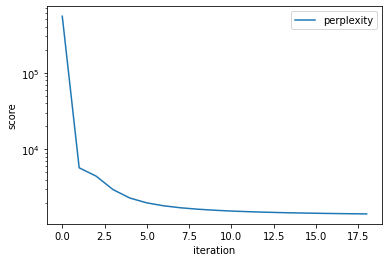

In [ ]:
plt.plot(model.score_tracker['perplexity'].value, label = 'perplexity')
plt.legend(loc = 'best')
plt.xlabel('iteration')
plt.ylabel('score')
plt.yscale('log')
plt.show()

In [ ]:
top_tokens = model.score_tracker['top-tokens'].last_tokens
for topic_name in model.topic_names[:10]:
    print(top_tokens[topic_name])

['учёный', 'исследование', 'который', 'исследователь', 'анализ', 'клетка', 'результат', 'это', 'вывод', 'журнал']
['испанский', 'английский', 'клуб', 'футболист', 'испания', 'барселона', 'реал', 'манчестер', 'челси', 'чемпион']
['германия', 'фрг', 'меркель', 'стол', 'канцлер', 'еда', 'ангел', 'который', 'свой', 'немец']
['создание', 'министерство', 'создать', 'предложение', 'база', 'предложить', 'зона', 'конференция', 'инициатива', 'который']
['решение', 'документ', 'принять', 'срок', 'должный', 'запрет', 'требование', 'соответствующий', 'это', 'разрешение']
['россия', 'российский', 'это', 'рф', 'наш', 'мид', 'заявить', 'москва', 'отметить', 'международный']
['ведомство', 'чиновник', 'внутренний', 'заместитель', 'департамент', 'министерство', 'дело', 'глава', 'анатолий', 'оборона']
['журналист', 'государственный', 'деятельность', 'служба', 'сми', 'контроль', 'паспорт', 'рубеж', 'власть', 'заниматься']
['директор', 'генеральный', 'исполнительный', 'гендиректор', 'аэрофлот', 'новосибирск

## Получаем тематические вектора

In [ ]:
X_train_pd = model.transform(bv_train)

In [ ]:
X_train = []
for i in tqdm(range(len(y_train))):
    X_train.append(X_train_pd[i].values)
X_train_np = np.array(X_train)
y_train_np = np.array(y_train)
X_train_np, y_train_np = shuffle(X_train_np, y_train_np,random_state=42)

  0%|          | 0/653795 [00:00<?, ?it/s]

In [ ]:
X_valid_pd = model.transform(bv_valid)
X_valid = []
for i in tqdm(range(len(y_valid))):
    X_valid.append(X_valid_pd[i].values)

  0%|          | 0/6604 [00:00<?, ?it/s]

## Классификатор

Логистическая регрессия

In [ ]:
classifier = LogisticRegression(random_state=42)
classifier.fit(X_train_np, y_train_np)
pred = classifier.predict(X_valid)
print(classification_report(y_valid, pred, zero_division=1))

              precision    recall  f1-score   support

        1999       1.00      0.00      0.00        19
        2000       0.50      0.04      0.08        69
        2001       0.33      0.02      0.04        96
        2002       0.13      0.04      0.06       143
        2003       0.30      0.09      0.14       134
        2004       0.17      0.15      0.16       183
        2005       0.15      0.17      0.16       240
        2006       0.19      0.10      0.13       256
        2007       0.13      0.04      0.06       236
        2008       0.15      0.15      0.15       332
        2009       0.14      0.24      0.18       423
        2010       0.16      0.12      0.14       375
        2011       0.17      0.11      0.13       384
        2012       0.15      0.20      0.17       427
        2013       0.16      0.21      0.18       387
        2014       0.17      0.07      0.10       309
        2015       0.15      0.13      0.14       387
        2016       0.20    

Random Forest

In [ ]:
classifier = RandomForestClassifier(n_estimators=10)
classifier.fit(X_train_np, y_train_np)
pred = classifier.predict(X_valid)
print(classification_report(y_valid, pred, zero_division=1))

              precision    recall  f1-score   support

        1999       0.08      0.11      0.09        19
        2000       0.05      0.06      0.05        69
        2001       0.05      0.05      0.05        96
        2002       0.11      0.11      0.11       143
        2003       0.11      0.12      0.11       134
        2004       0.14      0.14      0.14       183
        2005       0.10      0.12      0.11       240
        2006       0.12      0.12      0.12       256
        2007       0.07      0.08      0.08       236
        2008       0.12      0.15      0.13       332
        2009       0.15      0.21      0.17       423
        2010       0.11      0.12      0.11       375
        2011       0.14      0.14      0.14       384
        2012       0.16      0.16      0.16       427
        2013       0.09      0.08      0.09       387
        2014       0.21      0.16      0.18       309
        2015       0.21      0.18      0.19       387
        2016       0.26    

In [ ]:
classifier = RandomForestClassifier(n_estimators=20)
classifier.fit(X_train_np, y_train_np)
pred = classifier.predict(X_valid)
print(classification_report(y_valid, pred, zero_division=1))

              precision    recall  f1-score   support

        1999       0.20      0.05      0.08        19
        2000       0.11      0.06      0.08        69
        2001       0.08      0.05      0.06        96
        2002       0.19      0.15      0.16       143
        2003       0.22      0.19      0.20       134
        2004       0.12      0.10      0.11       183
        2005       0.15      0.17      0.16       240
        2006       0.13      0.10      0.11       256
        2007       0.14      0.11      0.12       236
        2008       0.17      0.21      0.18       332
        2009       0.19      0.26      0.22       423
        2010       0.12      0.12      0.12       375
        2011       0.19      0.21      0.20       384
        2012       0.13      0.13      0.13       427
        2013       0.17      0.16      0.16       387
        2014       0.27      0.20      0.23       309
        2015       0.26      0.21      0.23       387
        2016       0.25    

XGBoost

На всей выборке обучается слишком долго, а на фрагменте результат не лучше, чем на логистической регресии или RandomForest

In [ ]:
classifier = xgb.XGBClassifier()
classifier.fit(X_train_np[:20000], y_train_np[:20000])
pred = classifier.predict(X_valid)
print(classification_report(y_valid, pred, zero_division=1))

              precision    recall  f1-score   support

        1999       1.00      0.00      0.00        19
        2000       0.00      0.00      0.00        69
        2001       0.15      0.04      0.07        96
        2002       0.16      0.06      0.08       143
        2003       0.20      0.12      0.15       134
        2004       0.13      0.05      0.07       183
        2005       0.15      0.12      0.13       240
        2006       0.18      0.07      0.10       256
        2007       0.09      0.03      0.04       236
        2008       0.14      0.15      0.14       332
        2009       0.15      0.21      0.18       423
        2010       0.15      0.11      0.13       375
        2011       0.16      0.17      0.17       384
        2012       0.17      0.15      0.16       427
        2013       0.16      0.17      0.16       387
        2014       0.23      0.13      0.16       309
        2015       0.20      0.18      0.19       387
        2016       0.20    

# Мультимодальная модель (веса: 5, 5)
Добавим модальности месяца (@month с весом 5) и топика статьи (@tag с весом 5), без регуляризаторов

Обучаем новую модель или загружаем обученную

In [ ]:
TRAIN_NEW_MODEL=False
if TRAIN_NEW_MODEL:
    model = artm.ARTM(num_topics=200,
                  dictionary=dictionary, 
                  class_ids={'@default_class': 1.0,
                             '@tag': 5.0,
                             '@month': 5.0, 
                             })
    model.scores.add(artm.PerplexityScore(name='perplexity', dictionary=dictionary))
    model.scores.add(artm.TopTokensScore(name='top-tokens', num_tokens=10))
    model.scores.add(artm.SparsityPhiScore(name='sparsity_month', class_id='@month'))
    model.scores.add(artm.SparsityPhiScore(name='sparsity_tag', class_id='@tag'))

    iterator = tqdm(range(0,20))
    for i in iterator:
        model.fit_offline(bv_train, num_collection_passes=1)
        iterator.set_postfix({'perplexity': model.score_tracker['perplexity'].value[-1],
                              'sparsity_month': model.score_tracker['sparsity_month'].value[-1],
                              'sparsity_tag': model.score_tracker['sparsity_tag'].value[-1],  
                              })
        # save model on every iteration
        model.dump_artm_model(f'drive/MyDrive/ML/my_topicmodeling/model/MOD-default-tag5-month5-year-5_REG-no_{i}it')
else:
    model = artm.load_artm_model('./drive/MyDrive/ML/my_topicmodeling/model/MOD-default-tag5-month5_REG-no_19it')
    model.scores.add(artm.PerplexityScore(name='perplexity', dictionary=dictionary), overwrite=True)
    model.scores.add(artm.TopTokensScore(name='top-tokens', num_tokens=10), overwrite=True)
    model.scores.add(artm.SparsityPhiScore(name='sparsity_month', class_id='@month'), overwrite=True)
    model.scores.add(artm.SparsityPhiScore(name='sparsity_tag', class_id='@tag'), overwrite=True)

## Метрики в процессе обучения

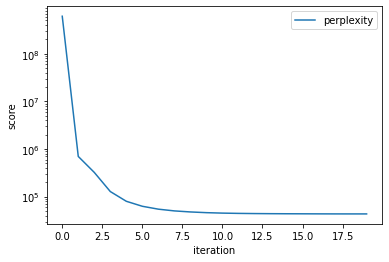

In [ ]:
plt.plot(model.score_tracker['perplexity'].value, label = 'perplexity')
plt.legend(loc = 'best')
plt.xlabel('iteration')
plt.ylabel('score')
plt.yscale('log')
plt.show()

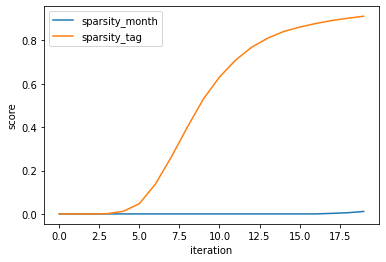

In [ ]:
plt.plot(model.score_tracker['sparsity_month'].value, label = 'sparsity_month')
plt.plot(model.score_tracker['sparsity_tag'].value, label = 'sparsity_tag')
plt.legend(loc = 'best')
plt.xlabel('iteration')
plt.ylabel('score')
plt.show()

In [ ]:
top_tokens = model.score_tracker['top-tokens'].last_tokens
for topic_name in model.topic_names[:10]:
    print(top_tokens[topic_name])

['финансовый', 'внешний', 'алкоголь', 'это', 'минфин', 'мочь', 'напиток', 'агентство', 'пиво', 'облигация']
['клуб', 'сезон', 'перейти', 'английский', 'испанский', 'переход', 'испания', 'контракт', 'манчестер', 'челси']
['ресторан', 'собака', 'питание', 'хозяин', 'еда', 'заведение', 'кафе', 'килограмм', 'который', 'кот']
['церковь', 'религиозный', 'храм', 'православный', 'рана', 'кирилл', 'собор', 'патриарх', 'бог', 'чувство']
['документ', 'случай', 'запретить', 'правило', 'запрет', 'требование', 'действовать', 'должный', 'соответствующий', 'ограничение']
['северный', 'мид', 'корея', 'визит', 'сотрудничество', 'сторона', 'совместный', 'кндр', 'отношение', 'делегация']
['министр', 'правительство', 'премьер', 'отставка', 'глава', 'премьера', 'кабинет', 'который', 'уйти', 'министерство']
['турист', 'поездка', 'отель', 'россиянин', 'гостиница', 'отдых', 'посетить', 'туристический', 'это', 'таиланд']
['директор', '2008', 'год', 'совет', '2006', '2009', '2007', 'генеральный', 'коммерсант', '

## Получаем тематические вектора

In [ ]:
X_train_pd = model.transform(bv_train)

In [ ]:
X_train = []
for i in tqdm(range(len(y_train))):
    X_train.append(X_train_pd[i].values)
X_train_np = np.array(X_train)
y_train_np = np.array(y_train)
X_train_np, y_train_np = shuffle(X_train_np, y_train_np,random_state=42)

  0%|          | 0/653795 [00:00<?, ?it/s]

In [ ]:
X_valid_pd = model.transform(bv_valid)
X_valid = []
for i in tqdm(range(len(y_valid))):
    X_valid.append(X_valid_pd[i].values)

  0%|          | 0/6604 [00:00<?, ?it/s]

## Классификатор

RandomForest

In [ ]:
classifier = RandomForestClassifier(n_estimators=20)
classifier.fit(X_train_np, y_train_np)
pred = classifier.predict(X_valid)
print(classification_report(y_valid, pred, zero_division=1))

              precision    recall  f1-score   support

        1999       0.00      0.00      0.00        19
        2000       0.17      0.10      0.13        69
        2001       0.05      0.04      0.04        96
        2002       0.12      0.10      0.11       143
        2003       0.15      0.13      0.14       134
        2004       0.14      0.13      0.14       183
        2005       0.15      0.16      0.16       240
        2006       0.17      0.17      0.17       256
        2007       0.15      0.12      0.13       236
        2008       0.19      0.25      0.22       332
        2009       0.27      0.34      0.30       423
        2010       0.19      0.17      0.18       375
        2011       0.23      0.26      0.25       384
        2012       0.24      0.24      0.24       427
        2013       0.28      0.27      0.27       387
        2014       0.29      0.18      0.23       309
        2015       0.24      0.22      0.23       387
        2016       0.31    

# Мультимодальная модель (веса: 2, 2)
Добавим модальности месяца (@month с весом 2) и топика статьи (@tag с весом 2), без регуляризаторов

Обучаем новую модель или загружаем обученную

In [ ]:
TRAIN_NEW_MODEL=False
if TRAIN_NEW_MODEL:
    model = artm.ARTM(num_topics=200,
                  dictionary=dictionary, 
                  class_ids={'@default_class': 1.0,
                             '@tag': 2.0,
                             '@month': 2.0, 
                             })
    model.scores.add(artm.PerplexityScore(name='perplexity', dictionary=dictionary))
    model.scores.add(artm.TopTokensScore(name='top-tokens', num_tokens=10))
    model.scores.add(artm.SparsityPhiScore(name='sparsity_month', class_id='@month'))
    model.scores.add(artm.SparsityPhiScore(name='sparsity_tag', class_id='@tag'))

    iterator = tqdm(range(0,20))
    for i in iterator:
        model.fit_offline(bv_train, num_collection_passes=1)
        iterator.set_postfix({'perplexity': model.score_tracker['perplexity'].value[-1],
                              'sparsity_month': model.score_tracker['sparsity_month'].value[-1],
                              'sparsity_tag': model.score_tracker['sparsity_tag'].value[-1],  
                              })
        # save model on every iteration
        model.dump_artm_model(f'drive/MyDrive/ML/my_topicmodeling/model/MOD-default-tag2-month2_REG-no_{i}it')
else:
    model = artm.load_artm_model('./drive/MyDrive/ML/my_topicmodeling/model/MOD-default-tag2-month2_REG-no_19it')
    model.scores.add(artm.PerplexityScore(name='perplexity', dictionary=dictionary), overwrite=True)
    model.scores.add(artm.TopTokensScore(name='top-tokens', num_tokens=10), overwrite=True)
    model.scores.add(artm.SparsityPhiScore(name='sparsity_month', class_id='@month'), overwrite=True)
    model.scores.add(artm.SparsityPhiScore(name='sparsity_tag', class_id='@tag'), overwrite=True)

  0%|          | 0/4 [00:00<?, ?it/s]

## Метрики в процессе обучения

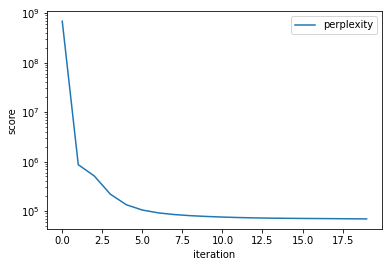

In [ ]:
plt.plot(model.score_tracker['perplexity'].value, label = 'perplexity')
plt.legend(loc = 'best')
plt.xlabel('iteration')
plt.ylabel('score')
plt.yscale('log')
plt.show()

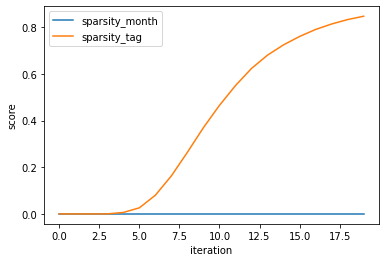

In [ ]:
plt.plot(model.score_tracker['sparsity_month'].value, label = 'sparsity_month')
plt.plot(model.score_tracker['sparsity_tag'].value, label = 'sparsity_tag')
plt.legend(loc = 'best')
plt.xlabel('iteration')
plt.ylabel('score')
plt.show()

In [ ]:
top_tokens = model.score_tracker['top-tokens'].last_tokens
for topic_name in model.topic_names[:10]:
    print(top_tokens[topic_name])

['вещество', 'содержание', 'алкоголь', 'напиток', 'вино', 'окружающий', 'химический', 'алкогольный', 'бутылка', 'пиво']
['испания', 'клуб', 'испанский', 'английский', 'перейти', 'переход', 'барселона', 'реал', 'манчестер', 'челси']
['питание', 'еда', 'стол', 'посоветовать', 'кот', 'который', 'пища', 'продукт', 'блюдо', 'попробовать']
['организация', 'институт', 'общество', 'инициатива', 'культура', 'идея', 'объединение', 'наука', 'создать', 'академия']
['решение', 'документ', 'принять', 'срок', 'должный', 'ввести', 'запрет', 'соответствующий', 'мера', 'ограничение']
['российский', 'россия', 'мид', 'иностранный', 'рф', 'посольство', 'визит', 'дипломат', 'заявить', 'это']
['министр', 'министерство', 'внутренний', 'отставка', 'заместитель', 'должность', 'дело', 'кабинет', 'назначение', 'ведомство']
['россиянин', 'турист', 'поездка', 'посетить', 'паспорт', 'отель', 'отдых', 'это', 'праздник', 'туристический']
['совет', 'директор', 'генеральный', 'председатель', 'руководитель', 'руководство

## Получаем тематические вектора

In [ ]:
X_train_pd = model.transform(bv_train)

In [ ]:
X_train = []
for i in tqdm(range(len(y_train))):
    X_train.append(X_train_pd[i].values)
X_train_np = np.array(X_train)
y_train_np = np.array(y_train)
X_train_np, y_train_np = shuffle(X_train_np, y_train_np,random_state=42)

  0%|          | 0/653795 [00:00<?, ?it/s]

In [ ]:
X_valid_pd = model.transform(bv_valid)
X_valid = []
for i in tqdm(range(len(y_valid))):
    X_valid.append(X_valid_pd[i].values)

  0%|          | 0/6604 [00:00<?, ?it/s]

## Классификатор

RandomForest

In [ ]:
classifier = RandomForestClassifier(n_estimators=20)
classifier.fit(X_train_np, y_train_np)
pred = classifier.predict(X_valid)
print(classification_report(y_valid, pred, zero_division=1))

              precision    recall  f1-score   support

        1999       0.20      0.05      0.08        19
        2000       0.20      0.09      0.12        69
        2001       0.17      0.11      0.14        96
        2002       0.14      0.11      0.12       143
        2003       0.14      0.12      0.13       134
        2004       0.13      0.11      0.12       183
        2005       0.13      0.15      0.14       240
        2006       0.16      0.17      0.17       256
        2007       0.10      0.08      0.09       236
        2008       0.14      0.17      0.15       332
        2009       0.22      0.30      0.26       423
        2010       0.19      0.20      0.19       375
        2011       0.19      0.22      0.21       384
        2012       0.19      0.18      0.18       427
        2013       0.18      0.17      0.17       387
        2014       0.23      0.17      0.20       309
        2015       0.26      0.25      0.25       387
        2016       0.29    

# Мультимодальная модель (разные веса: 3, 10)
Добавим модальности месяца (@month с весом 10) и топика статьи (@tag с весом 3), без регуляризаторов

Обучаем новую модель или загружаем обученную

In [ ]:
TRAIN_NEW_MODEL=True
if TRAIN_NEW_MODEL:
    model = artm.ARTM(num_topics=200,
                  dictionary=dictionary, 
                  class_ids={'@default_class': 1.0,
                             '@tag': 3.0,
                             '@month': 10.0, 
                             })
    model.scores.add(artm.PerplexityScore(name='perplexity', dictionary=dictionary))
    model.scores.add(artm.TopTokensScore(name='top-tokens', num_tokens=10))
    model.scores.add(artm.SparsityPhiScore(name='sparsity_month', class_id='@month'))
    model.scores.add(artm.SparsityPhiScore(name='sparsity_tag', class_id='@tag'))

    iterator = tqdm(range(10,20))
    for i in iterator:
        model.fit_offline(bv_train, num_collection_passes=1)
        iterator.set_postfix({'perplexity': model.score_tracker['perplexity'].value[-1],
                              'sparsity_month': model.score_tracker['sparsity_month'].value[-1],
                              'sparsity_tag': model.score_tracker['sparsity_tag'].value[-1],  
                              })
        # save model on every iteration
        model.dump_artm_model(f'drive/MyDrive/ML/my_topicmodeling/model/MOD-default-tag3-month10_REG-no_{i}it')
else:
    model = artm.load_artm_model('./drive/MyDrive/ML/my_topicmodeling/model/MOD-default-tag3-month10_REG-no_19it')
    model.scores.add(artm.PerplexityScore(name='perplexity', dictionary=dictionary), overwrite=True)
    model.scores.add(artm.TopTokensScore(name='top-tokens', num_tokens=10), overwrite=True)
    model.scores.add(artm.SparsityPhiScore(name='sparsity_month', class_id='@month'), overwrite=True)
    model.scores.add(artm.SparsityPhiScore(name='sparsity_tag', class_id='@tag'), overwrite=True)

  0%|          | 0/10 [00:00<?, ?it/s]

## Метрики в процессе обучения

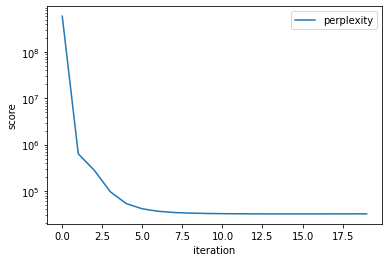

In [ ]:
plt.plot(model.score_tracker['perplexity'].value, label = 'perplexity')
plt.legend(loc = 'best')
plt.xlabel('iteration')
plt.ylabel('score')
plt.yscale('log')
plt.show()

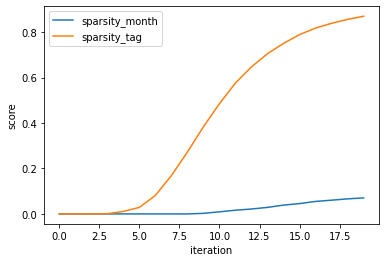

In [ ]:
plt.plot(model.score_tracker['sparsity_month'].value, label = 'sparsity_month')
plt.plot(model.score_tracker['sparsity_tag'].value, label = 'sparsity_tag')
plt.legend(loc = 'best')
plt.xlabel('iteration')
plt.ylabel('score')
plt.show()

In [ ]:
top_tokens = model.score_tracker['top-tokens'].last_tokens
for topic_name in model.topic_names[:10]:
    print(top_tokens[topic_name])

['использование', 'алкоголь', 'напиток', 'продавать', 'оборот', 'вино', 'содержание', 'бутылка', 'пиво', 'литр']
['испания', 'испанский', 'английский', 'клуб', 'барселона', 'реал', 'манчестер', 'челси', 'англия', 'футболист']
['ресторан', 'собака', 'питание', 'хозяин', 'заведение', 'еда', 'кафе', 'кот', 'посетитель', 'кошка']
['общество', 'церковь', 'религиозный', 'храм', 'православный', 'рана', 'кирилл', 'собор', 'академия', 'патриарх']
['случай', 'мера', 'ввести', 'запрет', 'ограничение', 'действовать', 'мочь', 'это', 'срок', 'введение']
['россия', 'российский', 'мид', 'иностранный', 'рф', 'заявить', 'посольство', 'сторона', 'визит', 'дипломат']
['министр', 'правительство', 'премьер', 'пост', 'отставка', 'глава', 'премьера', 'кабинет', 'уйти', 'министерство']
['турист', 'россиянин', 'поездка', 'отель', 'билет', 'посетить', 'гостиница', 'отдых', 'туристический', 'отправиться']
['совет', 'директор', 'генеральный', 'коммерсант', 'председатель', 'руководство', 'исполнительный', 'член', '

## Получаем тематические вектора

In [ ]:
X_train_pd = model.transform(bv_train)

In [ ]:
X_train = []
for i in tqdm(range(len(y_train))):
    X_train.append(X_train_pd[i].values)
X_train_np = np.array(X_train)
y_train_np = np.array(y_train)
X_train_np, y_train_np = shuffle(X_train_np, y_train_np,random_state=42)

  0%|          | 0/653795 [00:00<?, ?it/s]

In [ ]:
X_valid_pd = model.transform(bv_valid)
X_valid = []
for i in tqdm(range(len(y_valid))):
    X_valid.append(X_valid_pd[i].values)

  0%|          | 0/6604 [00:00<?, ?it/s]

## Классификатор

RandomForest

In [ ]:
classifier = RandomForestClassifier(n_estimators=20)
classifier.fit(X_train_np, y_train_np)
pred = classifier.predict(X_valid)
print(classification_report(y_valid, pred, zero_division=1))

              precision    recall  f1-score   support

        1999       0.50      0.05      0.10        19
        2000       0.11      0.07      0.09        69
        2001       0.08      0.05      0.06        96
        2002       0.18      0.15      0.16       143
        2003       0.16      0.14      0.15       134
        2004       0.13      0.13      0.13       183
        2005       0.20      0.21      0.21       240
        2006       0.16      0.13      0.14       256
        2007       0.12      0.09      0.10       236
        2008       0.18      0.23      0.20       332
        2009       0.25      0.35      0.29       423
        2010       0.17      0.18      0.18       375
        2011       0.19      0.21      0.20       384
        2012       0.23      0.25      0.24       427
        2013       0.22      0.22      0.22       387
        2014       0.25      0.17      0.20       309
        2015       0.27      0.26      0.26       387
        2016       0.27    

# Модель с регуляризаторами (Sparse + Decorrelator)

Как и в предыдущей модели, добавим модальности месяца (@month) и топика статьи (@tag). Кроме того, будем постепенно включать регуляризаторы: первые 8 итераций разреживающий (Sparse), затем, не выключая предыдущий, добавим декоррелирующий (Decorrelator) и обучим еще 12 итераций.

Обучаем новую модель или загружаем обученную

In [ ]:
TRAIN_NEW_MODEL=False
if TRAIN_NEW_MODEL:
    model = artm.ARTM(num_topics=200,
                  dictionary=dictionary, 
                  class_ids={'@default_class': 1.0,
                             '@tag': 5.0,
                             '@month': 5.0, 
                             })
    model.scores.add(artm.PerplexityScore(name='perplexity', dictionary=dictionary))
    model.scores.add(artm.TopTokensScore(name='top-tokens', num_tokens=10))
    model.scores.add(artm.SparsityPhiScore(name='sparsity_month', class_id='@month'))
    model.scores.add(artm.SparsityPhiScore(name='sparsity_tag', class_id='@tag'))
    
    # First regularizer (Sparse) -- 8 iterations
    model.regularizers.add(artm.SmoothSparsePhiRegularizer(name='smooth_sparse_phi_regularizer',
                                                      tau=-0.1, #sparse
                                                      #tau=10,  #smooth
                                                      class_ids=['@default_class', '@month', '@tag']))
    iterator = tqdm(range(0,8))
    for i in iterator:
        model.fit_offline(bv_train, num_collection_passes=1)
        iterator.set_postfix({'perplexity': model.score_tracker['perplexity'].value[-1],  
                              'sparsity_month': model.score_tracker['sparsity_month'].value[-1],
                              'sparsity_tag': model.score_tracker['sparsity_tag'].value[-1],
                              })
        model.dump_artm_model(f'drive/MyDrive/ML/my_topicmodeling/model/MOD-default-tag5-month5_REG-sparse{i}it-decor0it')
    
    # Add second regularizer (Decorrelator) -- 12 iterations
    model.regularizers.add(artm.DecorrelatorPhiRegularizer(name='decorrelator_phi_regularizer',
                                                      tau=10000,
                                                      class_ids=['@default_class', '@month', '@tag']))
    iterator = tqdm(range(1,13))
    for i in iterator:
        model.fit_offline(bv_train, num_collection_passes=1)
        iterator.set_postfix({'perplexity': model.score_tracker['perplexity'].value[-1],  
                              'sparsity_month': model.score_tracker['sparsity_month'].value[-1],
                              'sparsity_tag': model.score_tracker['sparsity_tag'].value[-1],
                              })

        model.dump_artm_model(f'drive/MyDrive/ML/my_topicmodeling/model/MOD-default-tag5-month5_REG-sparse{7+i}it-decor{i}it')
    
else:
    model = artm.load_artm_model('./drive/MyDrive/ML/my_topicmodeling/model/MOD-default-tag5-month5_REG-sparse19it-decor12it')
    model.scores.add(artm.PerplexityScore(name='perplexity', dictionary=dictionary), overwrite=True)
    model.scores.add(artm.TopTokensScore(name='top-tokens', num_tokens=10), overwrite=True)
    model.scores.add(artm.SparsityPhiScore(name='sparsity_month', class_id='@month'), overwrite=True)
    model.scores.add(artm.SparsityPhiScore(name='sparsity_tag', class_id='@tag'), overwrite=True)

## Метрики в процессе обучения

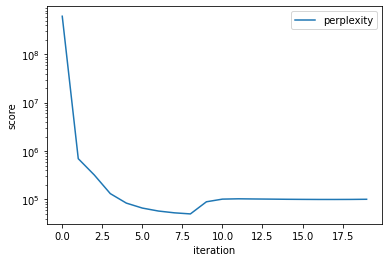

In [ ]:
plt.plot(model.score_tracker['perplexity'].value, label = 'perplexity')
plt.legend(loc = 'best')
plt.xlabel('iteration')
plt.ylabel('score')
plt.yscale('log')
plt.show()

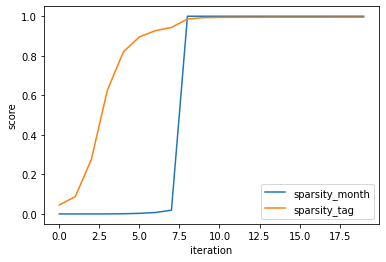

In [ ]:
plt.plot(model.score_tracker['sparsity_month'].value, label = 'sparsity_month')
plt.plot(model.score_tracker['sparsity_tag'].value, label = 'sparsity_tag')
plt.legend(loc = 'best')
plt.xlabel('iteration')
plt.ylabel('score')
plt.show()

In [ ]:
top_tokens = model.score_tracker['top-tokens'].last_tokens
for topic_name in model.topic_names[:10]:
    print(top_tokens[topic_name])

['финансовый', 'бюджет', 'расход', 'сокращение', 'сократить', 'кризис', 'дефицит', 'алкоголь', 'снизить', 'это']
['клуб', 'английский', 'перейти', 'испания', 'испанский', 'переход', 'манчестер', 'контракт', 'челси', 'сезон']
['собака', 'питание', 'килограмм', 'хозяин', 'еда', 'напиток', 'употребление', 'который', 'кот', 'лишний']
['церковь', 'религиозный', 'храм', 'православный', 'рана', 'кирилл', 'собор', 'бог', 'патриарх', 'священник']
['случай', 'ввести', 'правило', 'запретить', 'запрет', 'требование', 'ограничение', 'мочь', 'действовать', 'должный']
['мид', 'северный', 'корея', 'иностранный', 'посольство', 'визит', 'российский', 'дипломат', 'посол', 'кндр']
['министр', 'правительство', 'премьер', 'глава', 'отставка', 'премьера', 'кабинет', 'который', 'министерство', 'дело']
['россиянин', 'турист', 'поездка', 'отель', 'посетить', 'гостиница', 'отдых', 'отправиться', 'туристический', 'российский']
['культура', 'театр', 'артист', 'спектакль', 'сцена', 'театральный', 'профсоюз', 'имя',

## Получаем тематические вектора

In [ ]:
X_train_pd = model.transform(bv_train)

In [ ]:
X_train = []
for i in tqdm(range(len(y_train))):
    X_train.append(X_train_pd[i].values)
X_train_np = np.array(X_train)
y_train_np = np.array(y_train)
X_train_np, y_train_np = shuffle(X_train_np, y_train_np,random_state=42)

  0%|          | 0/653795 [00:00<?, ?it/s]

In [ ]:
X_valid_pd = model.transform(bv_valid)
X_valid = []
for i in tqdm(range(len(y_valid))):
    X_valid.append(X_valid_pd[i].values)

  0%|          | 0/6604 [00:00<?, ?it/s]

## Классификатор
RandomForest

In [ ]:
classifier = RandomForestClassifier(n_estimators=20)
classifier.fit(X_train_np, y_train_np)
pred = classifier.predict(X_valid)
print(classification_report(y_valid, pred, zero_division=1))

              precision    recall  f1-score   support

        1999       0.00      0.00      0.00        19
        2000       0.09      0.04      0.06        69
        2001       0.15      0.09      0.12        96
        2002       0.20      0.15      0.17       143
        2003       0.16      0.15      0.16       134
        2004       0.16      0.14      0.15       183
        2005       0.19      0.19      0.19       240
        2006       0.14      0.14      0.14       256
        2007       0.12      0.09      0.10       236
        2008       0.16      0.20      0.18       332
        2009       0.21      0.31      0.25       423
        2010       0.14      0.15      0.14       375
        2011       0.18      0.18      0.18       384
        2012       0.21      0.20      0.20       427
        2013       0.29      0.27      0.28       387
        2014       0.25      0.17      0.20       309
        2015       0.27      0.25      0.26       387
        2016       0.29    

# Модель с регуляризаторами (Smooth + Decorrelator)

Как и в предыдущей модели, добавим модальности месяца (@month) и топика статьи (@tag). Кроме того, будем постепенно включать регуляризаторы: первые 8 итераций сглаживающий (Smooth), затем, не выключая предыдущий, добавим декоррелирующий (Decorrelator) и обучим еще 12 итераций.

Обучаем новую модель или загружаем обученную

In [ ]:
TRAIN_NEW_MODEL=False
if TRAIN_NEW_MODEL:
    model = artm.ARTM(num_topics=200,
                  dictionary=dictionary, 
                  class_ids={'@default_class': 1.0,
                             '@tag': 5.0,
                             '@month': 5.0, 
                             })
    model.scores.add(artm.PerplexityScore(name='perplexity', dictionary=dictionary))
    model.scores.add(artm.TopTokensScore(name='top-tokens', num_tokens=10))
    model.scores.add(artm.SparsityPhiScore(name='sparsity_month', class_id='@month'))
    model.scores.add(artm.SparsityPhiScore(name='sparsity_tag', class_id='@tag'))
    
    # First regularizer (Smooth) -- 8 iterations
    model.regularizers.add(artm.SmoothSparsePhiRegularizer(name='smooth_sparse_phi_regularizer',
                                                      #tau=-0.1, #sparse
                                                      tau=10,  #smooth
                                                      class_ids=['@default_class', '@month', '@tag']))
    iterator = tqdm(range(0,8))
    for i in iterator:
        model.fit_offline(bv_train, num_collection_passes=1)
        iterator.set_postfix({'perplexity': model.score_tracker['perplexity'].value[-1],  
                              'sparsity_month': model.score_tracker['sparsity_month'].value[-1],
                              'sparsity_tag': model.score_tracker['sparsity_tag'].value[-1],
                              })
        model.dump_artm_model(f'drive/MyDrive/ML/my_topicmodeling/model/MOD-default-tag5-month5_REG-smooth{i}it-decor0it')
    
    # Add second regularizer (Decorrelator) -- 12 iterations
    model.regularizers.add(artm.DecorrelatorPhiRegularizer(name='decorrelator_phi_regularizer',
                                                      tau=10000,
                                                      class_ids=['@default_class', '@month', '@tag']))
    iterator = tqdm(range(1,13))
    for i in iterator:
        model.fit_offline(bv_train, num_collection_passes=1)
        iterator.set_postfix({'perplexity': model.score_tracker['perplexity'].value[-1],  
                              'sparsity_month': model.score_tracker['sparsity_month'].value[-1],
                              'sparsity_tag': model.score_tracker['sparsity_tag'].value[-1],
                              })

        model.dump_artm_model(f'drive/MyDrive/ML/my_topicmodeling/model/MOD-default-tag5-month5_REG-smooth{7+i}it-decor{i}it')
    
else:
    model = artm.load_artm_model('./drive/MyDrive/ML/my_topicmodeling/model/MOD-default-tag5-month5_REG-smooth19it-decor12it')
    model.scores.add(artm.PerplexityScore(name='perplexity', dictionary=dictionary), overwrite=True)
    model.scores.add(artm.TopTokensScore(name='top-tokens', num_tokens=10), overwrite=True)
    model.scores.add(artm.SparsityPhiScore(name='sparsity_month', class_id='@month'), overwrite=True)
    model.scores.add(artm.SparsityPhiScore(name='sparsity_tag', class_id='@tag'), overwrite=True)

## Метрики в процессе обучения

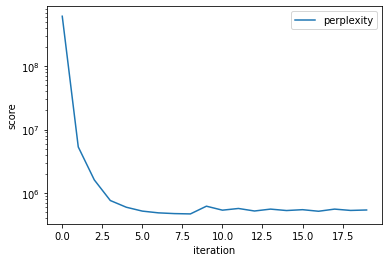

In [ ]:
plt.plot(model.score_tracker['perplexity'].value, label = 'perplexity')
plt.legend(loc = 'best')
plt.xlabel('iteration')
plt.ylabel('score')
plt.yscale('log')
plt.show()

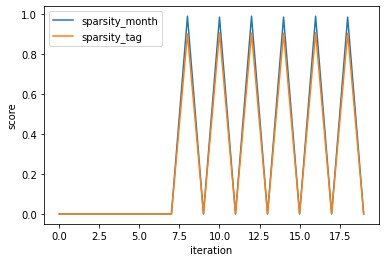

In [ ]:
plt.plot(model.score_tracker['sparsity_month'].value, label = 'sparsity_month')
plt.plot(model.score_tracker['sparsity_tag'].value, label = 'sparsity_tag')
plt.legend(loc = 'best')
plt.xlabel('iteration')
plt.ylabel('score')
plt.show()

In [ ]:
top_tokens = model.score_tracker['top-tokens'].last_tokens
for topic_name in model.topic_names[:10]:
    print(top_tokens[topic_name])

['соберицветафлаг', 'озерь', 'бажиев', 'имамур', 'корнский', 'почекун', 'вираппан', 'нехмад', 'шоумар', 'делануа']
['соберицветафлаг', 'озерь', 'бажиев', 'имамур', 'корнский', 'почекун', 'вираппан', 'нехмад', 'шоумар', 'делануа']
['соберицветафлаг', 'озерь', 'бажиев', 'имамур', 'корнский', 'почекун', 'вираппан', 'нехмад', 'шоумар', 'делануа']
['соберицветафлаг', 'озерь', 'бажиев', 'имамур', 'корнский', 'почекун', 'вираппан', 'нехмад', 'шоумар', 'делануа']
['соберицветафлаг', 'озерь', 'бажиев', 'имамур', 'корнский', 'почекун', 'вираппан', 'нехмад', 'шоумар', 'делануа']
['соберицветафлаг', 'озерь', 'бажиев', 'имамур', 'корнский', 'почекун', 'вираппан', 'нехмад', 'шоумар', 'делануа']
['соберицветафлаг', 'озерь', 'бажиев', 'имамур', 'корнский', 'почекун', 'вираппан', 'нехмад', 'шоумар', 'делануа']
['соберицветафлаг', 'озерь', 'бажиев', 'имамур', 'корнский', 'почекун', 'вираппан', 'нехмад', 'шоумар', 'делануа']
['соберицветафлаг', 'озерь', 'бажиев', 'имамур', 'корнский', 'почекун', 'вираппа

## Получаем тематические вектора

In [ ]:
X_train_pd = model.transform(bv_train)

In [ ]:
X_train = []
for i in tqdm(range(len(y_train))):
    X_train.append(X_train_pd[i].values)
X_train_np = np.array(X_train)
y_train_np = np.array(y_train)
X_train_np, y_train_np = shuffle(X_train_np, y_train_np,random_state=42)

  0%|          | 0/653795 [00:00<?, ?it/s]

In [ ]:
X_valid_pd = model.transform(bv_valid)
X_valid = []
for i in tqdm(range(len(y_valid))):
    X_valid.append(X_valid_pd[i].values)

  0%|          | 0/6604 [00:00<?, ?it/s]

## Классификатор
RandomForest

In [ ]:
classifier = RandomForestClassifier(n_estimators=20)
classifier.fit(X_train_np, y_train_np)
pred = classifier.predict(X_valid)
print(classification_report(y_valid, pred, zero_division=1))

              precision    recall  f1-score   support

        1999       1.00      0.00      0.00        19
        2000       0.00      0.00      0.00        69
        2001       0.14      0.01      0.02        96
        2002       0.33      0.01      0.03       143
        2003       0.00      0.00      0.00       134
        2004       0.20      0.01      0.01       183
        2005       0.00      0.00      0.00       240
        2006       0.38      0.01      0.02       256
        2007       0.00      0.00      0.00       236
        2008       0.07      0.01      0.02       332
        2009       0.11      0.23      0.15       423
        2010       0.18      0.02      0.03       375
        2011       0.08      0.03      0.04       384
        2012       0.12      0.23      0.15       427
        2013       0.35      0.24      0.28       387
        2014       0.27      0.03      0.05       309
        2015       0.21      0.05      0.08       387
        2016       0.09    

# Модель с регуляризатором (только Smooth)

Как и в предыдущей модели, добавим модальности месяца (@month) и топика статьи (@tag). Возьмем модель, обученную на 5 итерациях без регуляризаторов, затем добавим сглаживающий (Smooth) регуляризатор и обучим еще 15 итераций.

Обучаем новую модель или загружаем обученную

In [ ]:
TRAIN_NEW_MODEL=False
if TRAIN_NEW_MODEL:
    #pretrained model without regulariazers
    model = artm.load_artm_model('./drive/MyDrive/ML/my_topicmodeling/model/MOD-default-tag5-month5_REG-no4it')
    model.scores.add(artm.PerplexityScore(name='perplexity', dictionary=dictionary), overwrite=True)
    model.scores.add(artm.TopTokensScore(name='top-tokens', num_tokens=10), overwrite=True)
    model.scores.add(artm.SparsityPhiScore(name='sparsity_month', class_id='@month'), overwrite=True)
    model.scores.add(artm.SparsityPhiScore(name='sparsity_tag', class_id='@tag'), overwrite=True)
    # Add regularizer (Smooth) -- 15 iterations
    # model.regularizers.add(artm.SmoothSparsePhiRegularizer(name='smooth_sparse_phi_regularizer',
    #                                                   #tau=-0.1, #sparse
    #                                                   tau=10,  #smooth
    #                                                   class_ids=['@default_class', '@month', '@tag']))
    iterator = tqdm(range(11,15))
    for i in iterator:
        model.fit_offline(bv_train, num_collection_passes=1)
        iterator.set_postfix({'perplexity': model.score_tracker['perplexity'].value[-1],  
                              'sparsity_month': model.score_tracker['sparsity_month'].value[-1],
                              'sparsity_tag': model.score_tracker['sparsity_tag'].value[-1],
                              })
        model.dump_artm_model(f'drive/MyDrive/ML/my_topicmodeling/model/MOD-default-tag5-month5_REG-smooth{i}it-no4it')
    
else:
    model = artm.load_artm_model('./drive/MyDrive/ML/my_topicmodeling/model/MOD-default-tag5-month5_REG-smooth14it-no4it')
    model.scores.add(artm.PerplexityScore(name='perplexity', dictionary=dictionary), overwrite=True)
    model.scores.add(artm.TopTokensScore(name='top-tokens', num_tokens=10), overwrite=True)
    model.scores.add(artm.SparsityPhiScore(name='sparsity_month', class_id='@month'), overwrite=True)
    model.scores.add(artm.SparsityPhiScore(name='sparsity_tag', class_id='@tag'), overwrite=True)

## Метрики в процессе обучения

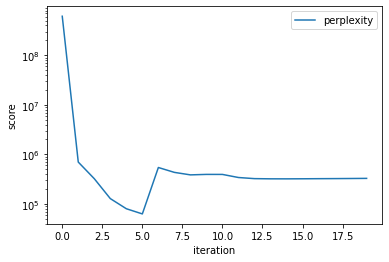

In [ ]:
plt.plot(model.score_tracker['perplexity'].value, label = 'perplexity')
plt.legend(loc = 'best')
plt.xlabel('iteration')
plt.ylabel('score')
plt.yscale('log')
plt.show()

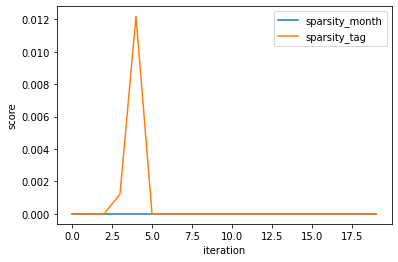

In [ ]:
plt.plot(model.score_tracker['sparsity_month'].value, label = 'sparsity_month')
plt.plot(model.score_tracker['sparsity_tag'].value, label = 'sparsity_tag')
plt.legend(loc = 'best')
plt.xlabel('iteration')
plt.ylabel('score')
plt.show()

In [ ]:
top_tokens = model.score_tracker['top-tokens'].last_tokens
for topic_name in model.topic_names[:10]:
    print(top_tokens[topic_name])

['nbclp', 'halfhalftravel', 'goldcoastsnakecatcher', 'wanderlust', 'казаров', 'mermaidthighs', 'kristenottea', 'vidframe', 'шоумар', 'парпий']
['nbclp', 'halfhalftravel', 'goldcoastsnakecatcher', 'wanderlust', 'казаров', 'mermaidthighs', 'kristenottea', 'vidframe', 'шоумар', 'парпий']
['брюква', 'болтунья', 'шнапс', 'окрошка', 'плов', 'noma', 'кинго', 'айран', 'юбари', 'нутрициолог']
['упц', 'патриархат', 'церковь', 'пцу', 'константинопольский', 'филарет', 'автокефалия', 'варфоломей', 'мп', 'вселенский']
['меховой', 'немаркированный', 'легпром', 'евтухов', 'чипирование', 'rfid', 'камвольный', 'identification', 'frequency', 'кожевенный']
['nbclp', 'halfhalftravel', 'goldcoastsnakecatcher', 'wanderlust', 'казаров', 'mermaidthighs', 'kristenottea', 'vidframe', 'шоумар', 'парпий']
['nbclp', 'halfhalftravel', 'goldcoastsnakecatcher', 'wanderlust', 'казаров', 'mermaidthighs', 'kristenottea', 'vidframe', 'шоумар', 'парпий']
['волченко', 'onetwotrip', 'aviasales', 'tvil', 'biletix', 'догузов',

## Получаем тематические вектора

In [ ]:
X_train_pd = model.transform(bv_train)

In [ ]:
X_train = []
for i in tqdm(range(len(y_train))):
    X_train.append(X_train_pd[i].values)
X_train_np = np.array(X_train)
y_train_np = np.array(y_train)
X_train_np, y_train_np = shuffle(X_train_np, y_train_np,random_state=42)

  0%|          | 0/653795 [00:00<?, ?it/s]

In [ ]:
X_valid_pd = model.transform(bv_valid)
X_valid = []
for i in tqdm(range(len(y_valid))):
    X_valid.append(X_valid_pd[i].values)

  0%|          | 0/6604 [00:00<?, ?it/s]

## Классификатор
RandomForest

In [ ]:
classifier = RandomForestClassifier(n_estimators=20)
classifier.fit(X_train_np, y_train_np)
pred = classifier.predict(X_valid)
print(classification_report(y_valid, pred, zero_division=1))

              precision    recall  f1-score   support

        1999       0.00      0.00      0.00        19
        2000       0.13      0.03      0.05        69
        2001       0.23      0.05      0.08        96
        2002       0.14      0.05      0.07       143
        2003       0.13      0.07      0.09       134
        2004       0.09      0.05      0.06       183
        2005       0.13      0.10      0.11       240
        2006       0.13      0.09      0.11       256
        2007       0.11      0.07      0.08       236
        2008       0.09      0.08      0.09       332
        2009       0.16      0.23      0.19       423
        2010       0.11      0.13      0.12       375
        2011       0.09      0.12      0.11       384
        2012       0.15      0.21      0.17       427
        2013       0.32      0.35      0.34       387
        2014       0.24      0.16      0.19       309
        2015       0.21      0.19      0.20       387
        2016       0.21    

# Модель с модальностью года
Как и раньше, добавим модальности месяца (@month) и топика статьи (@tag), но теперь еще добавим модальность года (@year); без регуляризаторов.

Обучаем новую модель или загружаем обученную

In [ ]:
TRAIN_NEW_MODEL=False
if TRAIN_NEW_MODEL:
    model = artm.ARTM(num_topics=200,
                  dictionary=dictionary, 
                  class_ids={'@default_class': 1.0,
                             '@tag': 5.0,
                             '@month': 5.0, 
                             '@year': 5.0, 
                             })
    model.scores.add(artm.PerplexityScore(name='perplexity', dictionary=dictionary))
    model.scores.add(artm.TopTokensScore(name='top-tokens', num_tokens=10))
    model.scores.add(artm.SparsityPhiScore(name='sparsity_month', class_id='@month'))
    model.scores.add(artm.SparsityPhiScore(name='sparsity_tag', class_id='@tag'))
    model.scores.add(artm.SparsityPhiScore(name='sparsity_year', class_id='@year'))

    iterator = tqdm(range(0,20))
    for i in iterator:
        model.fit_offline(bv_train, num_collection_passes=1)
        iterator.set_postfix({'perplexity': model.score_tracker['perplexity'].value[-1],
                              'sparsity_month': model.score_tracker['sparsity_month'].value[-1],
                              'sparsity_tag': model.score_tracker['sparsity_tag'].value[-1],  
                              'sparsity_year': model.score_tracker['sparsity_year'].value[-1],  
                              })
        # save model on every iteration
        model.dump_artm_model(f'drive/MyDrive/ML/my_topicmodeling/model/MOD-default-tag5-month5-year-5_REG-no_{i}it')
else:
    model = artm.load_artm_model('./drive/MyDrive/ML/my_topicmodeling/model/MOD-default-tag5-month5-year-5_REG-no_19it')
    model.scores.add(artm.PerplexityScore(name='perplexity', dictionary=dictionary), overwrite=True)
    model.scores.add(artm.TopTokensScore(name='top-tokens', num_tokens=10), overwrite=True)
    model.scores.add(artm.SparsityPhiScore(name='sparsity_month', class_id='@month'), overwrite=True)
    model.scores.add(artm.SparsityPhiScore(name='sparsity_tag', class_id='@tag'), overwrite=True)

## Метрики в процессе обучения

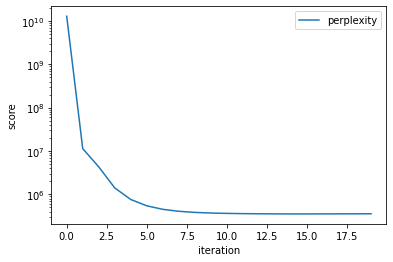

In [ ]:
plt.plot(model.score_tracker['perplexity'].value, label = 'perplexity')
plt.legend(loc = 'best')
plt.xlabel('iteration')
plt.ylabel('score')
plt.yscale('log')
plt.show()

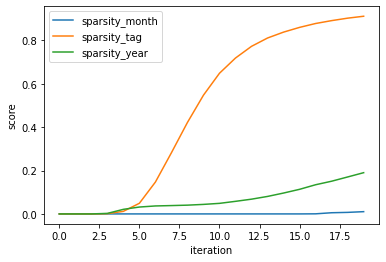

In [ ]:
plt.plot(model.score_tracker['sparsity_month'].value, label = 'sparsity_month')
plt.plot(model.score_tracker['sparsity_tag'].value, label = 'sparsity_tag')
plt.plot(model.score_tracker['sparsity_year'].value, label = 'sparsity_year')
plt.legend(loc = 'best')
plt.xlabel('iteration')
plt.ylabel('score')
plt.show()

In [ ]:
top_tokens = model.score_tracker['top-tokens'].last_tokens
for topic_name in model.topic_names[:10]:
    print(top_tokens[topic_name])

['алкоголь', 'тариф', 'снизить', 'напиток', 'вино', 'пиво', 'оборот', 'бутылка', 'повысить', 'минимальный']
['клуб', 'английский', 'испанский', 'переход', 'испания', 'англия', 'лондонский', 'манчестер', 'челси', 'перейти']
['ресторан', 'собака', 'питание', 'килограмм', 'еда', 'заведение', 'хозяин', 'вес', 'кот', 'кафе']
['церковь', 'религиозный', 'храм', 'православный', 'кирилл', 'собор', 'бог', 'патриарх', 'монастырь', 'рпц']
['документ', 'ввести', 'запрет', 'запретить', 'ограничение', 'введение', 'действовать', 'должный', 'требование', 'разрешить']
['вопрос', 'рф', 'россия', 'визит', 'российский', 'новость', 'заявить', 'отношение', 'сторона', 'риа']
['министр', 'премьер', 'пост', 'отставка', 'реклама', 'уйти', 'глава', 'кабинет', 'правительство', 'рекламный']
['турист', 'отель', 'поездка', 'гостиница', 'отдых', 'туристический', 'посетить', 'отправиться', 'курорт', 'путешествие']
['газета', 'писать', 'год', '2009', '2008', 'издание', 'коммерсант', 'который', 'данные', 'однако']
['герм

## Классификация модальности при помощи встроенного метода bigartm

Получаем матрицу условных вероятностей **p(модальность|документ)**. Остается определить наиболее вероятнуюю модальность (год) для каждого документа.

In [ ]:
year_pred_df = model.transform(batch_vectorizer=bv_valid,
                             predict_class_id='@year'
                            ).sort_index().drop(index='class_1914')
year_pred_df

,0,1,2,3,4,5,6,7,8,9,...,6594,6595,6596,6597,6598,6599,6600,6601,6602,6603
class_1999,8.037517e-07,3.797283e-07,0.000124,6.469717e-07,2.220530e-07,0.016162,0.000065,0.000003,0.007288,0.000220,...,0.000002,3.336381e-10,4.333756e-07,9.645365e-09,2.862532e-07,0.004245,0.000261,5.135530e-12,2.641102e-07,1.095656e-06
class_2000,5.600936e-05,6.933659e-04,0.002056,5.475787e-02,5.855435e-02,0.023417,0.000095,0.038325,0.000422,0.000500,...,0.001113,1.025656e-08,3.409399e-04,4.353763e-05,3.387973e-05,0.016903,0.003693,2.979725e-07,3.256455e-05,1.479630e-05
class_2001,2.015830e-06,1.343567e-03,0.052149,9.368160e-07,6.556306e-07,0.000790,0.000045,0.000028,0.000359,0.000026,...,0.000003,4.182775e-04,4.702211e-06,5.673837e-03,8.544675e-06,0.000083,0.012157,6.557455e-03,2.253430e-04,7.827165e-08
class_2002,1.404987e-03,3.567712e-04,0.000174,6.947487e-06,2.405366e-05,0.002704,0.031393,0.000241,0.057558,0.000005,...,0.031686,1.443846e-05,9.464624e-05,4.813926e-06,1.683364e-02,0.000005,0.000310,1.291718e-06,2.382838e-05,2.135246e-02
class_2003,2.648605e-04,3.569706e-04,0.000042,3.256865e-03,1.061952e-01,0.024584,0.036238,0.028355,0.002250,0.023831,...,0.005923,2.550531e-06,4.108452e-05,3.644955e-04,1.832355e-03,0.000602,0.000031,9.601030e-06,5.833770e-03,8.894088e-06
class_2004,9.023002e-04,1.879705e-02,0.000515,1.182541e-02,4.949083e-03,0.055455,0.029058,0.189863,0.036019,0.028408,...,0.021118,1.932839e-05,4.582713e-04,2.329278e-03,1.048972e-02,0.011328,0.000282,8.490919e-03,1.023603e-02,4.426749e-05
class_2005,5.347579e-02,8.569378e-02,0.032197,1.036202e-01,8.166721e-05,0.117494,0.086889,0.014559,0.123182,0.006747,...,0.000760,6.551836e-06,8.775127e-02,6.934526e-02,3.684661e-03,0.017098,0.001010,3.478090e-02,1.203920e-02,5.978060e-02
class_2006,1.846950e-02,2.673978e-02,0.051499,6.092610e-03,5.631102e-03,0.003616,0.163346,0.014948,0.044657,0.017253,...,0.032038,2.006520e-02,2.904698e-02,1.125280e-02,1.991372e-02,0.003089,0.028138,1.864749e-05,2.188180e-02,3.685746e-02
class_2007,9.895675e-03,6.112899e-02,0.000310,1.823324e-01,5.088084e-02,0.038687,0.183248,0.118579,0.015037,0.001192,...,0.000212,4.792132e-04,1.458159e-02,5.722445e-03,1.842976e-02,0.004176,0.010996,2.162107e-04,1.484229e-02,8.601295e-02
class_2008,4.419641e-02,1.172711e-01,0.075941,1.979006e-04,8.439274e-02,0.028459,0.004160,0.102551,0.016783,0.009466,...,0.017260,1.248072e-02,6.537471e-03,2.094767e-02,2.086923e-03,0.013057,0.046529,1.834396e-03,6.336663e-02,2.502499e-02


In [ ]:
year_pred_np = np.array(year_pred_df)
pred = (np.argmax(year_pred_np, axis=0) + 1999).astype(str)
print(len(pred), min(pred), max(pred))

6604 1999 2020


In [ ]:
print(classification_report(y_valid, pred, zero_division=1))

              precision    recall  f1-score   support

        1999       0.00      0.00      0.00        19
        2000       0.00      0.00      0.00        69
        2001       0.03      0.02      0.03        96
        2002       0.05      0.02      0.03       143
        2003       0.05      0.01      0.02       134
        2004       0.11      0.09      0.10       183
        2005       0.15      0.13      0.14       240
        2006       0.08      0.03      0.04       256
        2007       0.07      0.03      0.05       236
        2008       0.11      0.14      0.12       332
        2009       0.18      0.15      0.16       423
        2010       0.11      0.13      0.12       375
        2011       0.15      0.12      0.13       384
        2012       0.13      0.15      0.14       427
        2013       0.09      0.16      0.11       387
        2014       0.14      0.08      0.10       309
        2015       0.10      0.14      0.11       387
        2016       0.17    

## Получаем тематические вектора

In [ ]:
X_train_pd = model.transform(bv_train)

In [ ]:
X_train = []
for i in tqdm(range(len(y_train))):
    X_train.append(X_train_pd[i].values)
X_train_np = np.array(X_train)
y_train_np = np.array(y_train)
X_train_np, y_train_np = shuffle(X_train_np, y_train_np,random_state=42)

  0%|          | 0/653795 [00:00<?, ?it/s]

In [ ]:
X_valid_pd = model.transform(bv_valid)
X_valid = []
for i in tqdm(range(len(y_valid))):
    X_valid.append(X_valid_pd[i].values)

  0%|          | 0/6604 [00:00<?, ?it/s]

## Классификатор
RandomForest

In [ ]:
classifier = RandomForestClassifier(n_estimators=20)
classifier.fit(X_train_np, y_train_np)
pred = classifier.predict(X_valid)
print(classification_report(y_valid, pred, zero_division=1))

              precision    recall  f1-score   support

        1999       0.00      0.00      0.00        19
        2000       0.02      0.03      0.03        69
        2001       0.10      0.08      0.09        96
        2002       0.11      0.11      0.11       143
        2003       0.12      0.11      0.12       134
        2004       0.11      0.13      0.12       183
        2005       0.12      0.09      0.10       240
        2006       0.09      0.09      0.09       256
        2007       0.07      0.05      0.06       236
        2008       0.14      0.12      0.13       332
        2009       0.26      0.25      0.25       423
        2010       0.14      0.17      0.15       375
        2011       0.18      0.14      0.16       384
        2012       0.19      0.21      0.20       427
        2013       0.23      0.20      0.21       387
        2014       0.14      0.12      0.13       309
        2015       0.18      0.17      0.17       387
        2016       0.22    

Если читерить и добавить в тестовую выборку модальность года

In [ ]:
bv_valid = artm.BatchVectorizer(data_path='drive/MyDrive/ML/my_topicmodeling/vw_batches/batches_valid_withyear',
                                data_format='batches')

In [ ]:
X_valid_pd = model.transform(bv_valid)
X_valid = []
for i in tqdm(range(len(y_valid))):
    X_valid.append(X_valid_pd[i].values)

  0%|          | 0/6604 [00:00<?, ?it/s]

In [ ]:
classifier = RandomForestClassifier(n_estimators=20)
classifier.fit(X_train_np, y_train_np)
pred = classifier.predict(X_valid)
print(classification_report(y_valid, pred, zero_division=1))

              precision    recall  f1-score   support

        1999       0.50      0.05      0.10        19
        2000       0.74      0.41      0.52        69
        2001       0.77      0.46      0.58        96
        2002       0.66      0.48      0.55       143
        2003       0.80      0.70      0.75       134
        2004       0.76      0.74      0.75       183
        2005       0.86      0.82      0.84       240
        2006       0.79      0.85      0.82       256
        2007       0.82      0.80      0.81       236
        2008       0.85      0.87      0.86       332
        2009       0.87      0.94      0.90       423
        2010       0.77      0.78      0.77       375
        2011       0.85      0.92      0.88       384
        2012       0.80      0.86      0.83       427
        2013       0.82      0.87      0.85       387
        2014       0.83      0.78      0.80       309
        2015       0.81      0.80      0.80       387
        2016       0.76    

# Выводы
В задании предполагалось построить модель для классификации даты (года) публикации новостных заметок из выборки lenta.ru за 22 года. В качестве векторного представления текста рассматривались тематические векторы, которые получались с помощью модели ARTM из библиотеки bigARTM. 

Исходный вариант модели не предполагал регуляризаторов, а модальность была только одна, сам текст заметки (точнее набор слов). В процессе обучения перплексия монотонно убывала. В качестве классификаторов использовались логистическая регрессия, Random Forest, XGBoost. Все давали похожий результат, точность порядка 20%. XGBoost обучался на части выборки, так как процесс долгий. Для сравнения с другими моделями ARTM был выбран классификатор Random Forest на 20 деревьях, так как давал лучший результат за приемлемое время.

Добавление модальностей месяца и тега ожидаемо повысили точность классификации до 26%. Стоит отметить, что sparsity по модальности месяца очень слабо росла, по сравнению с модальностью тега. Ожидаемо, так как месяц слабо коррелирован с темой заметок. Попытки изменить веса модальностей оказались безуспешными, выше точность не стала.

Регуляризаторы добавлялись не сразу все, а постепенно, на разных итерациях. В случае Smooth + Decorrelator модель переобучилась, возможно, стоило выбрать другие параметры. В случае Sparse + Decorrelator тематические вектора получились нормальными, но повысить точность не вышло. При использовании только регуляризатора Smooth заметно некоторое переобучение и точность классификации упала до 20%.

В последней модели была добавлена модальность года. Если оставить в тестовой выборке модальность года, то, очевидно, точность получается высокой (80%). Если же не читерить, то точность классификации всего 19%, что хуже, чем без модальности года. Это ожидаемо, так как обучение идет с учетом информации о годе, но при формировании тестовых векторов она не учитывается. При наличии года  в качестве модальности есть возможность провести классификацию при помощи встроенных методов bigARTM. Можно получить матрицу условных вероятностей **p(модальность|документ)**, по которой далее определить наиболее вероятное значение модальности (года). Точность такого метода оказалась ниже других, всего 15%. Тем не менее, такой подход привлекает тем, что не требуется использовать дополнительный классификатор. 

Все рассматриваемые модели давали невысокую точность классификации (15-25%), что не сильно удивляет, так как очень часто тематика новостей не коррелирует с годом ее публикации. Однако, так как всего в выборке 22 класса, точность более 5% уже показывает, что модели обучаются и работают лучше, чем случайный выбор класса.
